In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Fine-Tuning GridSearch)

In [3]:
# 1. Chargement & Split
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv").iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Définition de la "Grille" de recherche
# On teste plusieurs "recettes"
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],              # Est-ce qu'on apprend par coeur ou pas ?
    'min_samples_leaf': [2, 5, 10],        # Taille minimale d'un groupe
    'class_weight': ['balanced', 'balanced_subsample'] # Gestion du déséquilibre
}

print(" Lancement du Fine-Tuning (GridSearch)")

# 3. (GridSearch)
# scoring='recall' car on veut maximiser la détection des départs !
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,                 # Validation croisée en 3 plis pour aller plus vite
    scoring='recall',     # On optimise le RAPPEL (Recall) un modèle qui fait quelques fausses alertes mais qui ne rate aucun départ.
    n_jobs=-1,            # Utilise tous les coeurs du processeur
    verbose=1
)

grid_search.fit(X_train, y_train)

# 4. Le Verdict
print(f"\n Meilleurs Paramètres trouvés : {grid_search.best_params_}")
print(f" Meilleur Score de Rappel (Validation) : {grid_search.best_score_:.2%}")

# On récupère le modèle champion pour la suite
best_model = grid_search.best_estimator_

 Lancement du Fine-Tuning (GridSearch)
Fitting 3 folds for each of 54 candidates, totalling 162 fits

 Meilleurs Paramètres trouvés : {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 300}
 Meilleur Score de Rappel (Validation) : 48.43%


# Analyse de l'importance Globale

Analyse de l'Importance Globale...


/var/folders/f9/qn36v8f56p3g0fwytdhmgk1m0000gn/T/ipykernel_24746/807389328.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_native, ax=axes[0], palette='viridis')
/var/folders/f9/qn36v8f56p3g0fwytdhmgk1m0000gn/T/ipykernel_24746/807389328.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_perm, ax=axes[1], palette='magma')


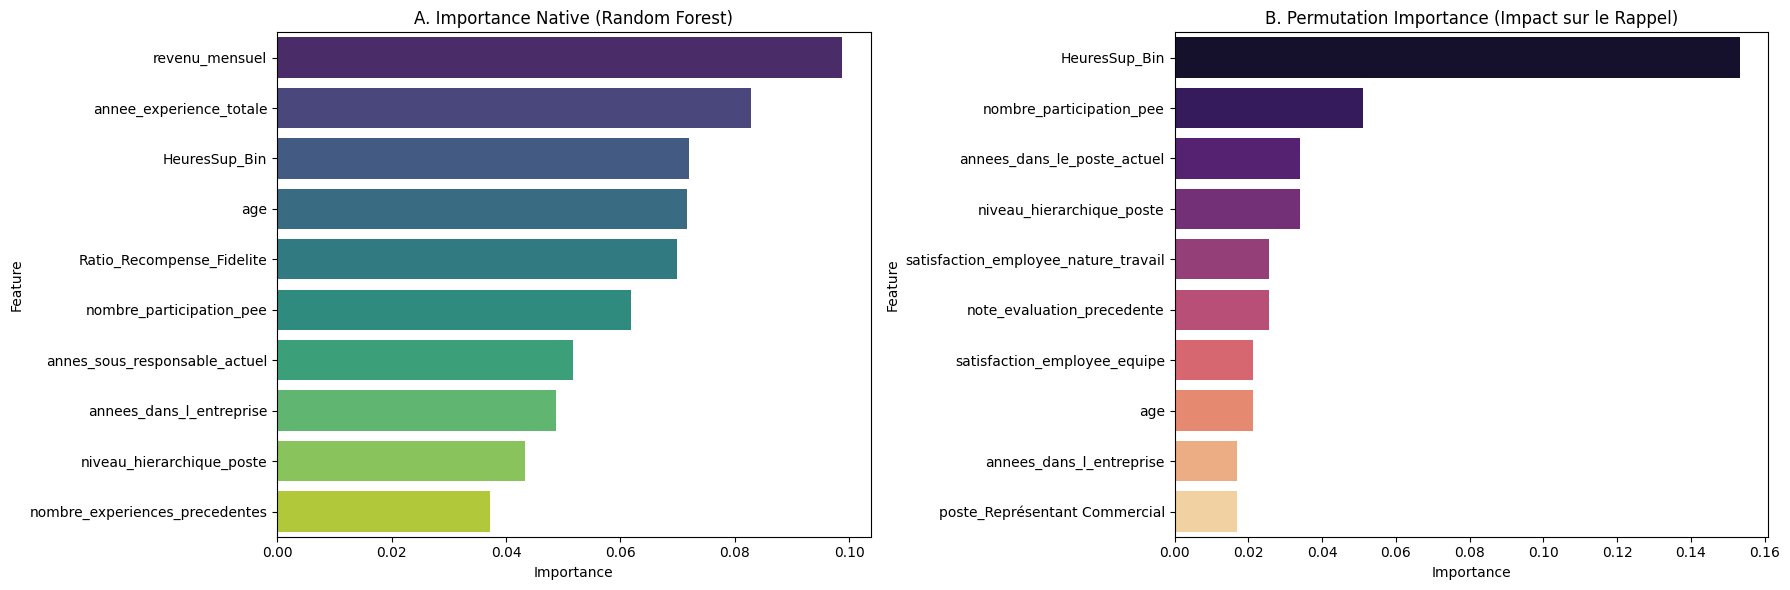

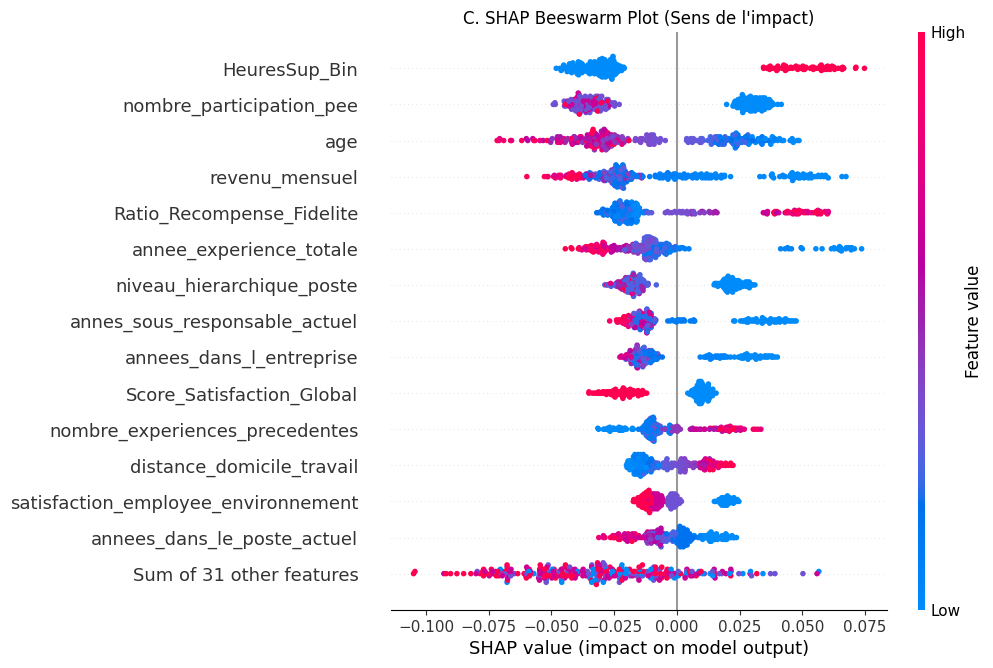

In [4]:
print("Analyse de l'Importance Globale...")

# --- A. Random Forest ---
# Rapide mais parfois biaisé vers les variables à haute cardinalité (beaucoup de valeurs uniques)
df_native = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# --- B. Sklearn ---
# Plus fiable car basé sur la baisse de performance réelle
perm_importance = permutation_importance(best_model, X_test, y_test, scoring='recall', random_state=42)
df_perm = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)

# --- VISUALISATION COMPARATIVE ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x='Importance', y='Feature', data=df_native, ax=axes[0], palette='viridis')
axes[0].set_title("A. Importance Native (Random Forest)")

sns.barplot(x='Importance', y='Feature', data=df_perm, ax=axes[1], palette='magma')
axes[1].set_title("B. Permutation Importance (Impact sur le Rappel)")

plt.tight_layout()
plt.show()

# --- C. SHAP BEESWARM  ---
# On utilise TreeExplainer car c'est un Random Forest
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test) # Nouvelle API SHAP

plt.figure()
plt.title("C. SHAP Beeswarm Plot (Sens de l'impact)")
# max_display=15 pour voir le top 15
shap.plots.beeswarm(shap_values[:, :, 1], max_display=15) # Classe 1 (Départ)
warnings.simplefilter(action='ignore', category=FutureWarning)


# ANALYSE LOCALE

ANALYSE LOCALE D'UN EMPLOYE QUI PART

 Analyse d'un cas individuel (Waterfall)...
Focus sur l'employé Test n°4


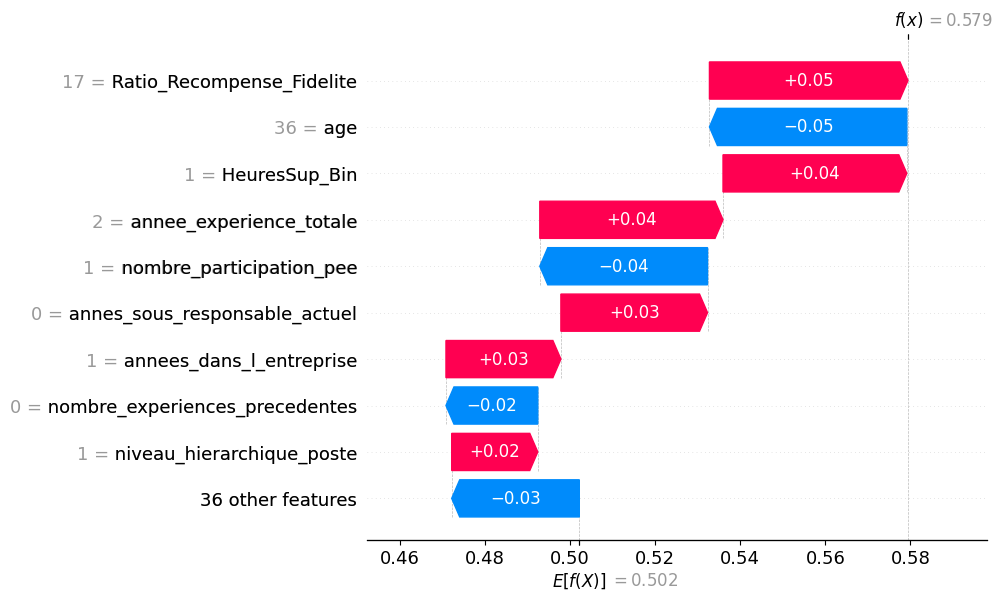

In [5]:
print(" Analyse d'un cas individuel (Waterfall)...")

# 1. On cherche un "Vrai Positif" (Quelqu'un qui est parti et qu'on a bien détecté)
y_pred = best_model.predict(X_test)
indices_reussite = [i for i, (vrai, pred) in enumerate(zip(y_test, y_pred)) if vrai == 1 and pred == 1]

if indices_reussite:
    idx_exemple = indices_reussite[0] # On prend le premier
    print(f"Focus sur l'employé Test n°{idx_exemple}")
    
    # 2. Le Waterfall Plot
    # shap_values[:,:,1] cible la classe "Départ"
    shap.plots.waterfall(shap_values[idx_exemple, :, 1])
else:
    print("Aucun démissionnaire détecté dans les premiers exemples.")

ANALYSE LOCALE D'UN EMPLOYE QUI RESTE


 Analyse d'un employé fidèle (Waterfall - Classe 0)...
Focus sur l'employé Test n°1 (Profil Fidèle)


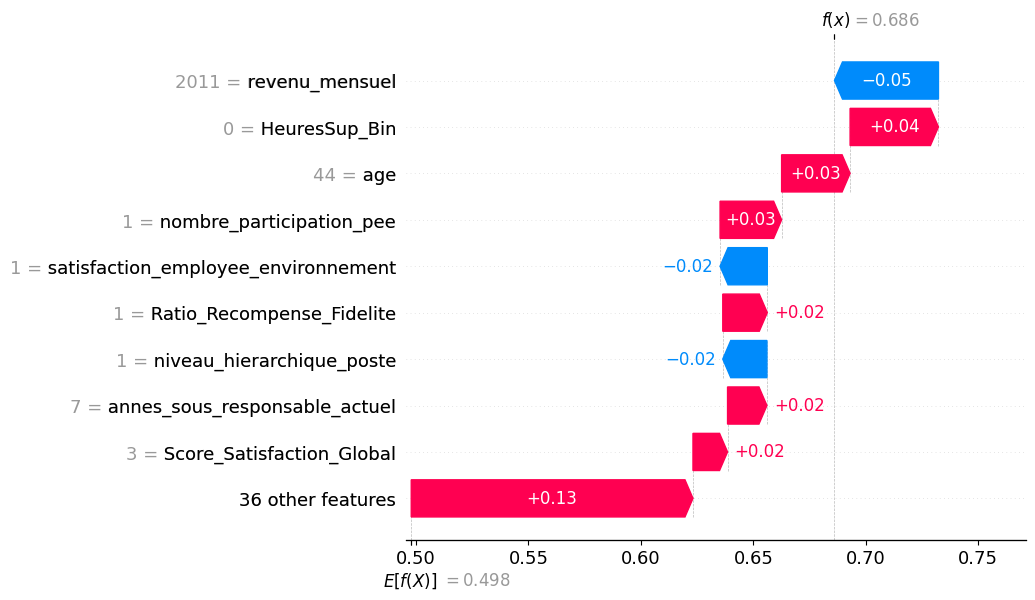

In [6]:
print("\n Analyse d'un employé fidèle (Waterfall - Classe 0)...")

# 1. On cherche un "Vrai Négatif" (Quelqu'un qui reste et que le modèle a bien prédit)
# y_test == 0 (Reste) et y_pred == 0 (Prédit "Reste")
indices_fidelite = [i for i, (vrai, pred) in enumerate(zip(y_test, y_pred)) if vrai == 0 and pred == 0]

if indices_fidelite:
    # On prend un exemple (le premier trouvé par exemple)
    idx_fidele = indices_fidelite[0] 
    print(f"Focus sur l'employé Test n°{idx_fidele} (Profil Fidèle)")
    
    # 2. Affichage du Waterfall Plot pour la classe 0 (Le maintien dans l'entreprise)
    # On utilise [:,:,0] pour expliquer pourquoi la probabilité de "Rester" est élevée
    shap.plots.waterfall(shap_values[idx_fidele, :, 0])
else:
    print("Aucun employé fidèle n'a été trouvé dans les prédictions.")

 # ANALYSE DE TENDANCE (SCATTER PLOT)

 Analyse fine de la variable : age
Lecture : Si les points montent, le risque augmente. S'ils descendent, le risque baisse.


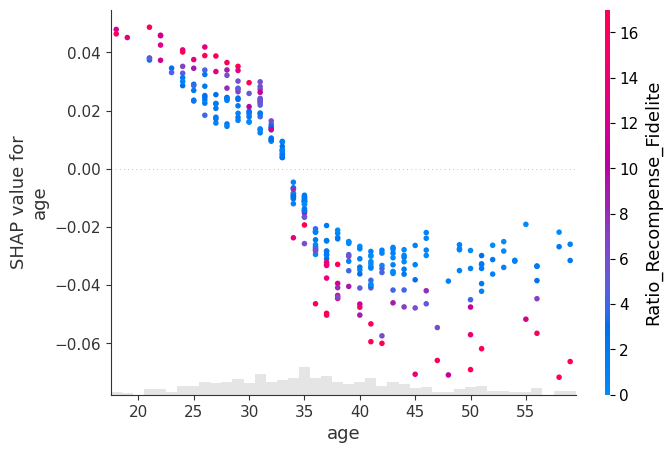

In [7]:
# Cela "aplatit" les dimensions pour que SHAP comprenne
shap_values_classe_1 = shap_values[:, :, 1]

# 2. Choix de la variable à analyser
feature_a_tester = "age"

print(f" Analyse fine de la variable : {feature_a_tester}")
print("Lecture : Si les points montent, le risque augmente. S'ils descendent, le risque baisse.")

# 3. Affichage du graphique
# color=shap_values_classe_1 permet de voir les interactions (automatique)
shap.plots.scatter(shap_values_classe_1[:, feature_a_tester], color=shap_values_classe_1)

 Analyse fine de la variable : Taux_Stagnation
Lecture : Si les points montent, le risque augmente. S'ils descendent, le risque baisse.


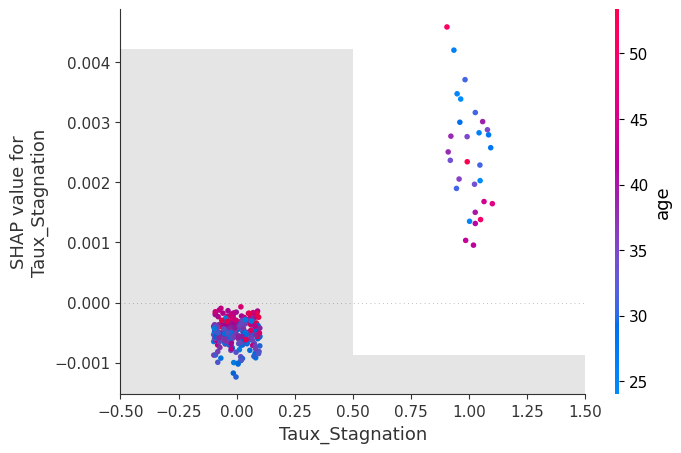

In [8]:
# Cela "aplatit" les dimensions pour que SHAP comprenne
shap_values_classe_1 = shap_values[:, :, 1]

# 2. Choix de la variable à analyser
feature_a_tester = "Taux_Stagnation"

print(f" Analyse fine de la variable : {feature_a_tester}")
print("Lecture : Si les points montent, le risque augmente. S'ils descendent, le risque baisse.")

# 3. Affichage du graphique
# color=shap_values_classe_1 permet de voir les interactions (automatique)
shap.plots.scatter(shap_values_classe_1[:, feature_a_tester], color=shap_values_classe_1)

 Analyse fine de la variable : Score_Satisfaction_Global
Lecture : Si les points montent, le risque augmente. S'ils descendent, le risque baisse.


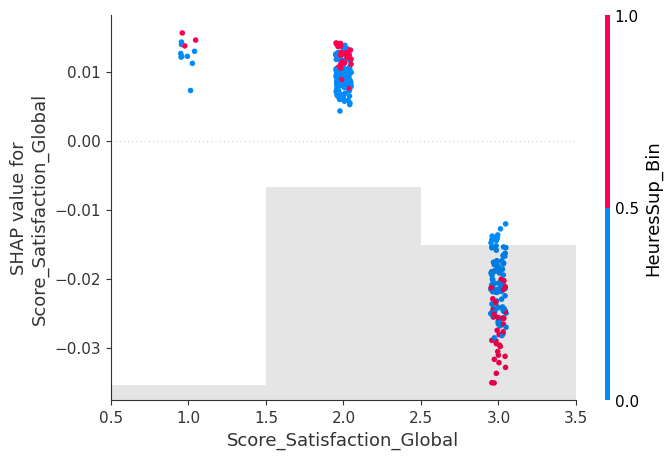

In [9]:
# Cela "aplatit" les dimensions pour que SHAP comprenne
shap_values_classe_1 = shap_values[:, :, 1]

# 2. Choix de la variable à analyser
feature_a_tester = "Score_Satisfaction_Global"

print(f" Analyse fine de la variable : {feature_a_tester}")
print("Lecture : Si les points montent, le risque augmente. S'ils descendent, le risque baisse.")

# 3. Affichage du graphique
# color=shap_values_classe_1 permet de voir les interactions (automatique)
shap.plots.scatter(shap_values_classe_1[:, feature_a_tester], color=shap_values_classe_1)

# OPTIMISATION DU SEUIL

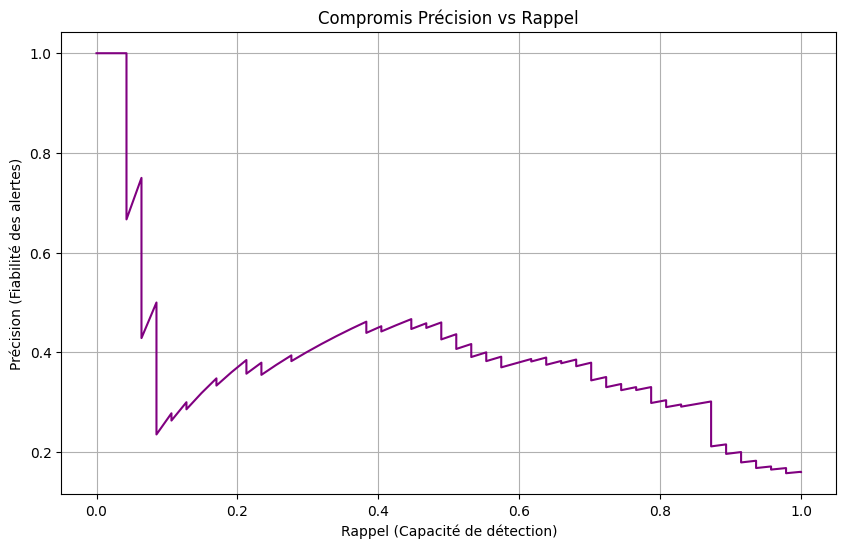

--- OPTIMISATION DU SEUIL ---
Meilleur seuil trouvé : 0.38
Rappel espéré à ce seuil : 0.87
Précision espérée à ce seuil : 0.30

Conclusion pour le métier :
Au lieu de décider à 0.50, on devrait considérer qu'un employé est à risque dès 0.38 de probabilité.


In [10]:
# 1. Obtenir les probabilités brutes 
# On récupère la probabilité d'appartenir à la classe 1 (Départ)
y_scores = grid_search.predict_proba(X_test)[:, 1]

# 2. Calculer la courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Afficher la Courbe
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', label='Courbe PR')
plt.title('Compromis Précision vs Rappel')
plt.xlabel('Rappel (Capacité de détection)')
plt.ylabel('Précision (Fiabilité des alertes)')
plt.grid(True)
plt.show()

# 4. Trouver le meilleur seuil pour favoriser le Rappel (ex: on veut F2-Score)
# On cherche le seuil qui maximise un F-Score pondéré (bêta=2 privilégie le Rappel)
fscore = (5 * precision * recall) / (4 * precision + recall)
ix = np.argmax(fscore)
best_thresh = thresholds[ix]

print(f"--- OPTIMISATION DU SEUIL ---")
print(f"Meilleur seuil trouvé : {best_thresh:.2f}")
print(f"Rappel espéré à ce seuil : {recall[ix]:.2f}")
print(f"Précision espérée à ce seuil : {precision[ix]:.2f}")

print("\nConclusion pour le métier :")
print(f"Au lieu de décider à 0.50, on devrait considérer qu'un employé est à risque dès {best_thresh:.2f} de probabilité.")